In [1]:
import time
import glob
import copy
import re
import csv
import zlib
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation
from IPython.display import display,clear_output,HTML

import seaborn as sns
from decimal import Decimal
#import rebound

# Data read-in

In [24]:
folderpath = '4.5e9_1000_Rcrit3_NoOverlapChem' #The format should always be 'timescale_#ofcomets(notnecessarilycorrect)_criticalradiusorIAS15_chemdistribution'
migration = 'UNMigrate' #'NoMigrate'
n_comets = 10
plot_observed_comets = "off"

In [25]:
#Get relevant meta-data from folderpath name
meta = re.search('4.5e9_(.*)_(.*)_(.*)', folderpath)
ChemDist,Rcrit = meta.group(3),meta.group(2)
print(ChemDist,Rcrit)

NoOverlapChem Rcrit3


In [26]:
#Give each comet a name (unique sequence of numbers) based on comet number and file number (optional)
def generate_comet_name(comet_number, migration_file_number):
    return zlib.adler32("{:d}{:d}{:d}{:d}".format(comet_number, migration_file_number, comet_number*migration_file_number, comet_number+migration_file_number).encode('utf-8')) & 0xffffffff

In [27]:
def read_migration_data(filename, snapshot_num, comets_total_singlesnapshot):
    #print(filename)
    t_list, snapshot_rows = [], []
    migration_file_num = int(filename.split("_")[-1].replace(".csv", ""))
    with open(filename, 'r') as fle:
        i = 0
        for line in fle:
            if ("Load error" in line):
                fle.readline()
                break
            else:
                break
        fle.readline()
        while (i < snapshot_num):
            fle.readline()
            while (fle.readline().rstrip() != ""):
                continue
            else:
                i = i + 1
        while (len(snapshot_rows) == 0 or snapshot_rows[-1].rstrip() != ""):
            snapshot_rows.append(fle.readline())
        snapshot_rows.pop()
        snapshot_rows = [i.rstrip().split(",") for i in snapshot_rows]

        #Give each comet a name (unique sequence of numbers) based on comet number and file number (optional)
        #snapshot_rows = [{generate_comet_name(int(i[0].split("_")[-1]), migration_file_num): np.array(i[1:], dtype=np.float64)} for i in snapshot_rows if i[0] in ["Comet_*"]]
        
        #Convert to dataframe with temporary headings
        if ("LinearChem" in ChemDist):
            snapshot_df = pd.DataFrame(snapshot_rows,columns=["1","2","3","4"])
        elif ("BinaryChem" in ChemDist or "NoOverlapChem" in ChemDist):
            snapshot_df = pd.DataFrame(snapshot_rows,columns=["1","2","3","4","5"])

        def label_chemdist(row):
            try:
                if row["CO"] + row["CO2"] > 1.:
                    return "Both"
                if row["CO"] == 1:
                    return "CO"
                if row["CO2"] == 1:
                    return "CO2"
                return "None"
            except:
                return "None"

        #Clean dataframe
        #snapshot_df = snapshot_df.dropna(axis=0,how="any")
        snapshot_df["Object"] = snapshot_df.iloc[:,0]
        snapshot_df["a"] = pd.to_numeric(snapshot_df.iloc[:,1])
        snapshot_df["e"] = pd.to_numeric(snapshot_df.iloc[:,2])
        if ("BinaryChem" in ChemDist) or ("NoOverlapChem" in ChemDist):
            snapshot_df["CO"] = pd.to_numeric(snapshot_df.iloc[:,3],errors='coerce')
            snapshot_df["CO2"] = pd.to_numeric(snapshot_df.iloc[:,4],errors='coerce')
            snapshot_df["ChemDist"] = snapshot_df.apply(lambda row:label_chemdist(row),axis=1)
            snapshot_df = snapshot_df.drop(snapshot_df.columns[:-6], axis=1)
        elif ("LinearChem" in ChemDist):
            snapshot_df["Chem_ratio"] = pd.to_numeric(snapshot_df.iloc[:,3],errors='coerce')
            snapshot_df = snapshot_df.drop(snapshot_df.columns[:-4], axis=1)

        searchfor = ["Comet_"+str(i) for i in range(n_comets)]
        comets_total_singlesnapshot += snapshot_df["Object"].str.contains('|'.join(searchfor)).sum()
        #comets_total_singlesnapshot += snapshot_df[snapshot_df['Object'].str.contains('Comet')].count()

    return snapshot_df, comets_total_singlesnapshot

## Clean data

In [28]:
#Data read-in
comets_total_singlesnapshot = 0
orbits_data = []

try:
    #Try reading processed single data file, clean data if it doesn't exist
    with open('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv', 'r') as fle:
        t_list = [float(i) for i in fle.readline().split(",")]
    df = pd.read_csv('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv', skiprows=[0,1], skip_blank_lines=False)
    df_list = np.split(df, df[df.isnull().all(1)].index)
    for snapshot_df_conc in df_list:
        snapshot_df_conc = snapshot_df_conc.dropna(how="any",axis=0)
        if snapshot_df_conc.empty:
            pass
        else:
            orbits_data.append(snapshot_df_conc)

except FileNotFoundError:
    #Take the list of snapshot times, required for time plots
    with open(glob.glob('./Cluster_Output/'+folderpath+'/'+migration+'*.csv')[0]) as fle:
        for line in fle:
            if ("Load error" in line):
                pass
            else:
                t_list = [float(i) for i in line.replace("[", "").replace("]", "").split(",")]
                break
        with open('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv', 'w') as csvfile:
            output_writer = csv.writer(csvfile, delimiter=',')
            output_writer.writerow(t_list)
            output_writer.writerow("")

    #print(t_list)

    t1 = time.time()
    with open('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv', 'a') as csvfile:
        for i in range(len(t_list)):
            snapshot_df_list = []
            for filename in glob.glob('./Cluster_Output/'+folderpath+'/'+migration+'*.csv'): 
                snapshot_df, comets_total_singlesnapshot = read_migration_data(filename, i, comets_total_singlesnapshot)
                snapshot_df_list.append(snapshot_df)
                del snapshot_df
                #print(t_list)
                #print(comets_total_singlesnapshot)
            snapshot_df_conc = pd.concat(snapshot_df_list)
            del snapshot_df_list

            #Delete rows that have any NaNs
            snapshot_df_conc = snapshot_df_conc.dropna(axis=0,how="any")

            #Write to single csv file for ease of access
            if i == 0:
                snapshot_df_conc.to_csv(csvfile, header=True, index=False)
            else:
                snapshot_df_conc.to_csv(csvfile, header=False, index=False)
                
            output_writer = csv.writer(csvfile, delimiter=',')
            output_writer.writerow("")

            orbits_data.append(snapshot_df_conc)

            print("\r",i/len(t_list)*100,"percent complete", end="")
            clear_output(wait=True)
    t2 = time.time()
    print("Time elapsed (minutes):",(t2-t1)/60)

# Plotting Functions

In [29]:
#Histogram (semi-major axis) plot function
def plot_a_hist(orbits, sim_num, timescale, Rcrit, ChemDist):
    fig, ax = plt.subplots(figsize=(16,8))
    binwidth = 1
    plt.hist(orbits, bins=np.arange(0., 2000. + binwidth, binwidth))
    plt.title("Final semi-major axes of comets, "+str(sim_num)+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,fontsize=18)
    plt.xlabel("Orbit Distance (AU)",fontsize=16)
    plt.ylabel("Frequency",fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid()
    plt.savefig("Semi-major Axis Frequency, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", bbox_inches='tight', format='png')

In [30]:
#Histogram (eccentricity) plot function
def plot_e_hist(orbits, sim_num, timescale, Rcrit, ChemDist):
    fig, ax = plt.subplots(figsize=(16,8))
    binwidth = 0.01
    plt.hist(orbits, bins=np.arange(0, 1 + binwidth, binwidth))
    plt.title("Final eccentricities of comets, "+str(sim_num)+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,fontsize=18)
    plt.xlabel("Eccentricity",fontsize=16)
    plt.ylabel("Frequency",fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid()
    plt.savefig("Eccentricity Frequency, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", bbox_inches='tight', format='png')

In [31]:
#Plot final semi-major axis vs. eccentricity
def plot_a_e(df_list, df_obs, sim_num, timescale, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        scatters = []
        groups = df_list[-1].groupby("ChemDist")
        for name, group in groups:
            scat = ax.scatter(group.a, group.e, data=df_list[-1], marker='o', label=name, sizes=[8])
            scatters.append(scat)
        
        if plot_observed_comets == "on":
            groups2 = df_obs.groupby("Chem_obs")
            for name2, group2 in groups2:
                ax.plot(group2.a_obs, group2.e_obs, marker='*', linestyle='', ms=16, label=name2)
        else:
            pass

        ax.legend()
        #fg = sns.FacetGrid(data=df, hue="ChemDist", hue_order=["None","CO2","CO","Both"], size=7, aspect=2)
        #fg.map(plt.scatter, "a", "e", s=8).add_legend()
        
    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        scatters = []
        groups = df_list[-1].groupby("ChemDist")
        for name, group in groups:
            scat = ax.scatter(group.a, group.e, data=df_list[-1], marker='o', label=name, sizes=[8])
            scatters.append(scat)

        '''if plot_observed_comets == "on":
            scat2 = plt.scatter(df_obs["a_obs"], df_obs["e_obs"],
                         c=df_obs["Chem_obs"].apply(lambda x: colors[x]), s=256, marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df_obs, scatter=False, fit_reg=False,color=".1")
        else:
            pass'''

        ax.legend()
        
    elif ("LinearChem" in ChemDist):        
        fig, ax = plt.subplots(figsize=(16,8))
        scat = plt.scatter(df_list[-1]["a"], df_list[-1]["e"], c=df_list[-1]["Chem_ratio"], s=6, cmap="viridis")
        
        if plot_observed_comets == "on":
            scat2 = plt.scatter(df_obs["a_obs"], df_obs["e_obs"],
                         c=df_obs["Chem_ratio_obs"], s=256, cmap="viridis", marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df_obs, scatter=False, fit_reg=False,color=".1")
        else:
            pass
        
        rp = sns.regplot("a", "e", data=df_list[-1], scatter=False, fit_reg=False,color=".1")
        cbar = plt.colorbar(scat)
        cbar.ax.set_ylabel("CO/CO2 Ratio", rotation=270)

    if max(df_list[-1]["a"]) > 50.:
        plt.xlim([0,400.])
    if max(df_list[-1]["e"]) > 1.:
        plt.ylim([0,1.])
    plt.xlabel("Semi-major axis (AU)", fontsize=16)
    plt.ylabel("Eccentricity", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title("Semi-major Axis vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    plt.savefig("Semi-major Axis vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
                bbox_inches="tight", format="png")

In [32]:
#Animate semi-major axis vs. eccentricity over time
def anim_a_e(df_list, df_obs, sim_num, timescale, t_list, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        scatters = []
        labels = df_list[0]["ChemDist"]
        groups = df_list[0].groupby("ChemDist")
        for name, group in groups:
            scat = ax.scatter(group.a, group.e, data=df_list[0], marker='o', label=name, sizes=[8])
            scatters.append(scat)
        
        if plot_observed_comets == "on":
            scat2 = plt.scatter(df_obs["a_obs"], df_obs["e_obs"],
                         c=df_obs["Chem_obs"].apply(lambda x: colors[x]), s=256, marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df_obs, scatter=False, fit_reg=False,color=".1")
        else:
            pass

        ax.legend()
        
    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        scatters = []
        labels = df_list[0]["ChemDist"]
        groups = df_list[0].groupby("ChemDist")
        for name, group in groups:
            scat = ax.scatter(group.a, group.e, data=df_list[0], marker='o', label=name, sizes=[8])
            scatters.append(scat)
            
        '''if plot_observed_comets == "on":
            scat2 = plt.scatter(df_obs["a_obs"], df_obs["e_obs"],
                         c=df_obs["Chem_obs"].apply(lambda x: colors[x]), s=256, marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df_obs, scatter=False, fit_reg=False,color=".1")
        else:
            pass'''

        ax.legend()
        
    elif ("LinearChem" in ChemDist):        
        fig, ax = plt.subplots(figsize=(16,8))
        scat = plt.scatter(df_list[0]["a"], df_list[0]["e"], c=df_list[0]["Chem_ratio"], s=4, cmap="viridis")
        
        rp = sns.regplot("a", "e", data=df_list[0], scatter=False, fit_reg=False,color=".1")
        cbar = plt.colorbar(scat)
        cbar.ax.set_ylabel("CO/CO2 Ratio", rotation=270)

    time_text = ax.text(0.75, 0.05,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)

    def update(frame_number):
        if ("NoOverlapChem" in ChemDist) or ("BinaryChem" in ChemDist):
            #print(t_list.index(frame_number))
            groups = df_list[t_list.index(frame_number)].groupby("ChemDist")
            for i, (name, group) in enumerate(groups):
                a_list, e_list = np.array(group.a), np.array(group.e)
                a_e = np.column_stack((a_list,e_list))
                scatters[i].set_offsets(a_e)
        elif ("LinearChem" in ChemDist):
            a_list, e_list = np.array(df_list[t_list.index(frame_number)]["a"]), np.array(df_list[t_list.index(frame_number)]["e"])
            a_e = np.column_stack((a_list,e_list))
            scat.set_offsets(a_e)
        time_text.set_text('Time = %.5E years' % Decimal(frame_number))
        return scat, time_text

    if max(df_list[-1]["a"]) > 50.:
        plt.xlim([0,400.])
    plt.ylim([0,1.])
    plt.xlabel("Semi-major axis (AU)", fontsize=16)
    plt.ylabel("Eccentricity", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title("Semi-major Axis vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    #plt.savefig("Semi-major Axis vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, Rcrit = "+Rcrit+" "+ChemDist+".png", 
    #            bbox_inches="tight", format="png")
    
    #animation.embed_limit = 500
    anim = animation.FuncAnimation(fig, update, frames=t_list, interval=10)
    
    return anim

In [33]:
#Plot final semi-major axis vs. eccentricity
def plot_chem_a(df_list, df_obs, sim_num, timescale, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.stripplot(df_list[-1]["ChemDist"], df_list[-1]["a"], size=4, jitter=True)
        
        if plot_observed_comets == "on":
            points2 = plt.scatter(df_obs["Chem_obs"], df_obs["a_obs"], s=256, marker="*")
        else:
            pass
        
        x_label = "Chemical Distribution"

        #fg = sns.FacetGrid(data=df, hue="ChemDist", hue_order=["None","CO2","CO","Both"], size=7, aspect=2)
        #fg.map(plt.scatter, "a", "e", s=8).add_legend()
    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.stripplot(df_list[-1]["ChemDist"], df_list[-1]["a"], size=4, jitter=True)
        
        #if plot_observed_comets == "on":
        #    points2 = plt.scatter(df_obs["Chem_obs"], df_obs["a_obs"], s=256, marker="*")
        #else:
        #    pass
        
        x_label = "Chemical Distribution"

        #fg = sns.FacetGrid(data=df, hue="ChemDist", hue_order=["CO","CO2"], size=7, aspect=2)
        #fg.map(plt.scatter, "a", "e", s=8).add_legend()
    elif ("LinearChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.regplot(df_list[-1]["Chem_ratio"], df_list[-1]["a"], scatter_kws={'s':4})
        
        #if plot_observed_comets == "on":
        #    points2 = plt.scatter(df_obs["Chem_ratio_obs"], df_obs["a_obs"], s=256, marker="*")
        #else:
        #    pass
        
        x_label = "Chem Ratio (CO\CO2)"

    if max(df_list[-1]["a"]) > 50.:
        plt.ylim([0,400.])
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel("Semi-major Axis (AU)", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title(x_label+" vs. Semi-major Axis (AU), "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    
    plt.savefig(x_label+" vs. Semi-major Axis (AU), "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
                bbox_inches="tight", format="png")

In [34]:
#Plot final semi-major axis vs. eccentricity
def plot_chem_e(df_list, df_obs, sim_num, timescale, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.stripplot(df_list[-1]["ChemDist"], df_list[-1]["e"], size=4, jitter=True)
        
        if plot_observed_comets == "on":
            points2 = plt.scatter(df_obs["Chem_obs"], df_obs["a_obs"], s=256, marker="*")
        else:
            pass
        
        x_label = "Chemical Distribution"

    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.stripplot(df_list[-1]["ChemDist"], df_list[-1]["e"], size=4, jitter=True)
        
        #if plot_observed_comets == "on":
        #    points2 = plt.scatter(df_obs["Chem_obs"], df_obs["a_obs"], s=256, marker="*")
        #else:
        #    pass
        
        x_label = "Chemical Distribution"

    elif ("LinearChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.regplot(df_list[-1]["Chem_ratio"], df_list[-1]["e"], scatter_kws={'s':4})
        
        #if plot_observed_comets == "on":
        #    points2 = plt.scatter(df_obs["Chem_ratio_obs"], df_obs["e_obs"], s=256, marker="*")
        #else:
        #    pass
        
        x_label = "Chem Ratio (CO\CO2)"

    if max(df_list[-1]["e"]) > 1.:
        plt.ylim([0,1.])
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel("Eccentricity", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title(x_label+" vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    
    plt.savefig(x_label+" vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
                bbox_inches="tight", format="png")

In [35]:
#Number of comets over time
def plot_n_time(n_comets_list, t_list, timescale, Rcrit, ChemDist):
    fig, ax = plt.subplots(figsize=(8,8))
    ax = sns.regplot(x=t_list, y=n_comets_list, ci=None, truncate=True)
    plt.title("Number of Surviving Comets vs Time, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.savefig("Number of Surviving Comets vs Time, t_max = "+timescale+" yrs, s"+Rcrit+" "+ChemDist+".png", 
            bbox_inches="tight", format="png")
    plt.xlabel("Time (Years)", fontsize=16)
    plt.ylabel("Number of Surviving Comets (distance < 4e4 AU)", fontsize=16)
    plt.grid()

In [36]:
'''#Distance vs. time plot function
def plot_a_time(a_orbits_list, t_list, sim_num, Rcrit):
    colors_list = ["C0","C1","C2","C3"]
    planets_list = ["Jupiter","Saturn","Uranus","Neptune"]
    patches = []
    
    fig, ax = plt.subplots(figsize=(8,8)) 
    
    #Plot planets as thicker lines
    for m in range(4):
        plt.plot(t_list,list(map(list, zip(*a_orbits_list)))[m], linewidth=5)
        
    #Pick five random comets to plot
    for n in comet_index_shuffle: 
        plt.plot(t_list,list(map(list, zip(*a_orbits_list)))[n])
        axes = plt.gca()
        if max(list(map(list, zip(*a_orbits_list)))[n]) > 70. or min(list(map(list, zip(*a_orbits_list)))[n]) < 0.:
            axes.set_ylim([0,70])
            
    for l in range(len(colors_list)):
        patches.append(mpatches.Patch(color=colors_list[l], label=planets_list[l]))
        
    plt.legend(handles=patches, loc="best")
    plt.title("Semi-major axis vs Time, "+str(sim_num))
    plt.xlabel("Time (Years)")
    plt.ylabel("Semi-Major Axis (AU)")
    plt.grid()
                        
    return comet_index_shuffle'''

'#Distance vs. time plot function\ndef plot_a_time(a_orbits_list, t_list, sim_num, Rcrit):\n    colors_list = ["C0","C1","C2","C3"]\n    planets_list = ["Jupiter","Saturn","Uranus","Neptune"]\n    patches = []\n    \n    fig, ax = plt.subplots(figsize=(8,8)) \n    \n    #Plot planets as thicker lines\n    for m in range(4):\n        plt.plot(t_list,list(map(list, zip(*a_orbits_list)))[m], linewidth=5)\n        \n    #Pick five random comets to plot\n    for n in comet_index_shuffle: \n        plt.plot(t_list,list(map(list, zip(*a_orbits_list)))[n])\n        axes = plt.gca()\n        if max(list(map(list, zip(*a_orbits_list)))[n]) > 70. or min(list(map(list, zip(*a_orbits_list)))[n]) < 0.:\n            axes.set_ylim([0,70])\n            \n    for l in range(len(colors_list)):\n        patches.append(mpatches.Patch(color=colors_list[l], label=planets_list[l]))\n        \n    plt.legend(handles=patches, loc="best")\n    plt.title("Semi-major axis vs Time, "+str(sim_num))\n    plt.xlabel("

In [37]:
'''#Distance vs. time plot function
def plot_e_time(e_orbits_list, t_list, sim_num, Rcrit):
    colors_list = ["C0","C1","C2","C3"]
    planets_list = ["Jupiter","Saturn","Uranus","Neptune"]
    patches = []
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    #Plot planets as thicker lines
    for m in range(4):
        plt.plot(t_list,e_orbits_list, linewidth=5)
        
    for n in comet_index_shuffle: 
        plt.plot(t_list,list(map(list, zip(*e_orbits_list)))[n])
        axes = plt.gca()
        if max(list(map(list, zip(*e_orbits_list)))[n]) > 1.:
            axes.set_ylim([0,1.])
            
    for l in range(len(colors_list)):
        patches.append(mpatches.Patch(color=colors_list[l], label=planets_list[l]))
        
    plt.legend(handles=patches, loc="best")
    plt.title("Eccentricity vs Time, "+str(sim_num))
    plt.xlabel("Time (Years)")
    plt.ylabel("Eccentricity")
    plt.grid()'''

'#Distance vs. time plot function\ndef plot_e_time(e_orbits_list, t_list, sim_num, Rcrit):\n    colors_list = ["C0","C1","C2","C3"]\n    planets_list = ["Jupiter","Saturn","Uranus","Neptune"]\n    patches = []\n    \n    fig, ax = plt.subplots(figsize=(8,8))\n    \n    #Plot planets as thicker lines\n    for m in range(4):\n        plt.plot(t_list,e_orbits_list, linewidth=5)\n        \n    for n in comet_index_shuffle: \n        plt.plot(t_list,list(map(list, zip(*e_orbits_list)))[n])\n        axes = plt.gca()\n        if max(list(map(list, zip(*e_orbits_list)))[n]) > 1.:\n            axes.set_ylim([0,1.])\n            \n    for l in range(len(colors_list)):\n        patches.append(mpatches.Patch(color=colors_list[l], label=planets_list[l]))\n        \n    plt.legend(handles=patches, loc="best")\n    plt.title("Eccentricity vs Time, "+str(sim_num))\n    plt.xlabel("Time (Years)")\n    plt.ylabel("Eccentricity")\n    plt.grid()'

# Manual addition of observed comets and their respective volatiles

In [38]:
#Add in known comet volatile ratios from current research
Names_obs = ["1P/Halley","153P/Ikeya-Zhang","8P/Tuttle","64P/Swift-Gehrels","19P/Borrelly","103P/Hartley 2","144P/Kushida",
            "67P/Churyumov-Gerasimenko","73P/Schwassmann-Wachmann 3-C","157P/Tritton","22P/Kopff","81P/Wild 2","88P/Howell",
            "118P/Shoemaker-Levy 4","9P/Tempel 1","116P/Wild 4","C/1979 Y1 Bradfield","C/1989 X1 Austin",
            "C/1990 K1 Levy","C/1995 O1 Hale-Bopp","C/1996 B2 Hyakutake","C/1999 H1 Lee","C/1999 S4 (LINEAR)",
            "C/2000 WM1 LINEAR","C/2001 A2 LINEAR","C/2004 Q2 Machholz","C/2006 OF2 Broughton","C/2007 N3 Lulin",
            "C/2007 Q3 Siding Spring","C/2008 Q3 Garradd","C/2009 P1 Garradd"]
a_obs = [17.834,51.214,5.702,4.451,3.609,3.469,3.866,3.464,3.063,3.412,3.459,3.452,3.110,3.466,3.146,3.485,45.259,
        -1529.839,-1498.666,182.052,2272.079,2775.377,-7227.979,-2286.223,2530.530,2403.325,-3101.674,72415.000,-9454.117,
        8926.033,-1555.613]
e_obs = [0.967,0.990,0.820,0.688,0.623,0.694,0.628,0.640,0.692,0.601,0.544,0.537,0.562,0.428,0.510,0.372,0.988,
        1.000,1.001,0.995,0.999,0.999,1.000,1.000,0.999,0.999,1.001,0.999,1.000,0.999,1.000]
Chem_obs = ["Both","CO","CO","CO2","CO2","Both","Both","CO2","CO","CO2","CO2","CO2","CO2","CO2","Both","CO2","Both",
           "Both","Both","CO","CO","CO","CO","CO","CO","CO","CO2","Both","CO2","Both","Both"]

observed_orbits = pd.DataFrame({'Names_obs' : Names_obs,
                                'a_obs' : a_obs,
                                'e_obs' : e_obs,
                                'Chem_obs' : Chem_obs})
observed_orbits

,Chem_obs,Names_obs,a_obs,e_obs
0,Both,1P/Halley,17.834,0.967
1,CO,153P/Ikeya-Zhang,51.214,0.990
2,CO,8P/Tuttle,5.702,0.820
3,CO2,64P/Swift-Gehrels,4.451,0.688
4,CO2,19P/Borrelly,3.609,0.623
5,Both,103P/Hartley 2,3.469,0.694
6,Both,144P/Kushida,3.866,0.628
7,CO2,67P/Churyumov-Gerasimenko,3.464,0.640
8,CO,73P/Schwassmann-Wachmann 3-C,3.063,0.692
9,CO2,157P/Tritton,3.412,0.601


# Do analysis

In [39]:
#Total number of original comets
comets_total = len(orbits_data[0].index)
print(comets_total)

990


In [40]:
#Quickly check a snapshot
print(orbits_data[-1])

            Object           a         e   CO  CO2 ChemDist
8028417   Comet_95   84.570998  0.658913  0.0  1.0      CO2
8028418   Comet_98  198.265670  0.887174  0.0  1.0      CO2
8028419  Comet_103   51.953319  0.409577  0.0  1.0      CO2
8028420  Comet_106  593.461483  0.949541  0.0  1.0      CO2
8028421  Comet_107  404.377982  0.922705  0.0  1.0      CO2
8028422  Comet_108  372.760880  0.915807  0.0  1.0      CO2
8028423  Comet_109  384.372911  0.919693  0.0  1.0      CO2
8028424  Comet_110  346.659664  0.929195  0.0  1.0      CO2
8028425  Comet_112  317.729015  0.900177  0.0  1.0      CO2
8028426   Comet_40   48.023392  0.226038  0.0  1.0      CO2
8028427   Comet_50  283.491109  0.878899  0.0  1.0      CO2
8028428   Comet_53  196.736818  0.828187  0.0  1.0      CO2
8028429   Comet_58   49.364030  0.178303  0.0  1.0      CO2
8028430   Comet_59  149.995163  0.781061  0.0  1.0      CO2
8028431   Comet_60   49.348503  0.087914  0.0  1.0      CO2
8028432   Comet_62  542.597777  0.940771

# Plots

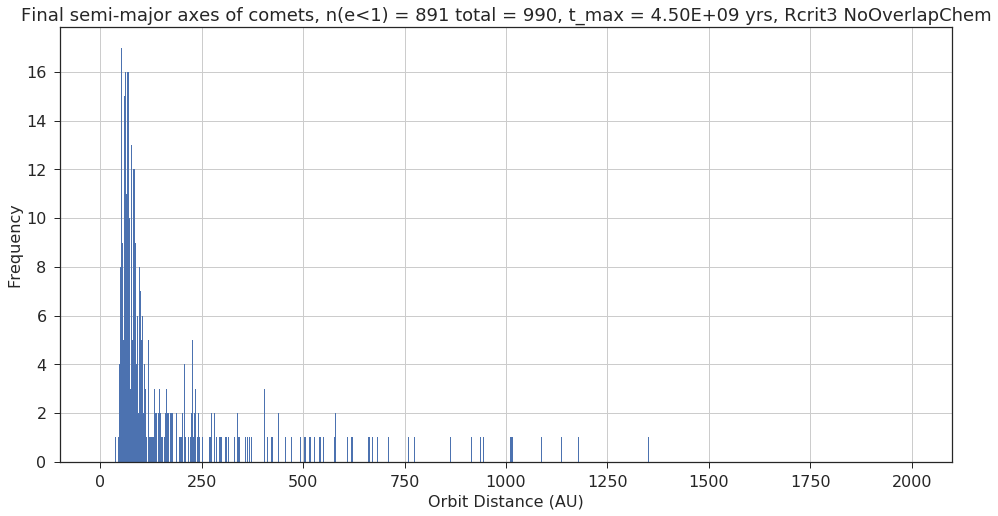

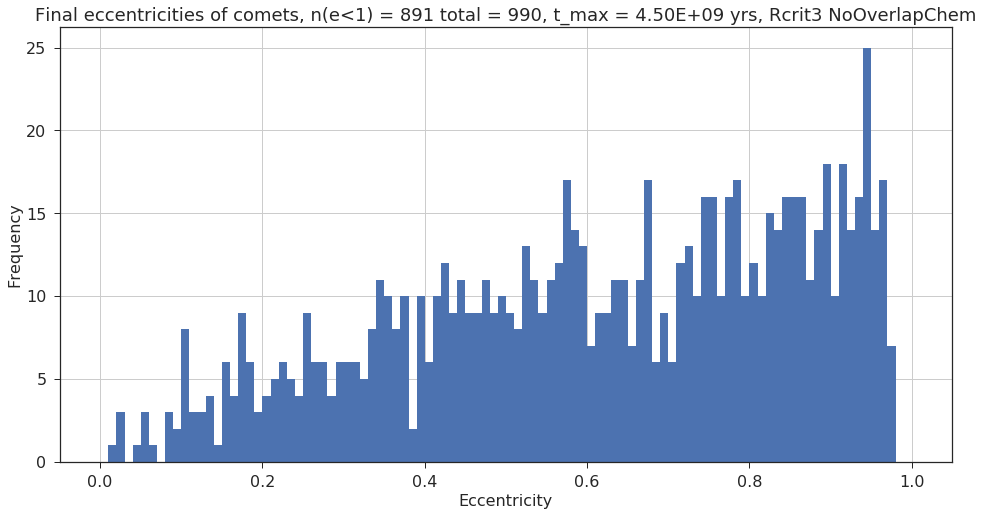

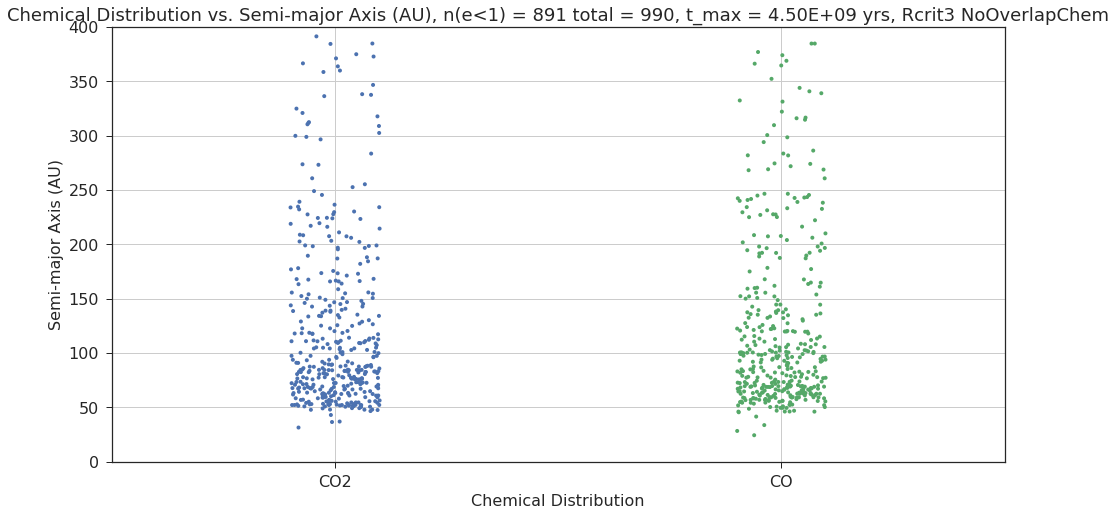

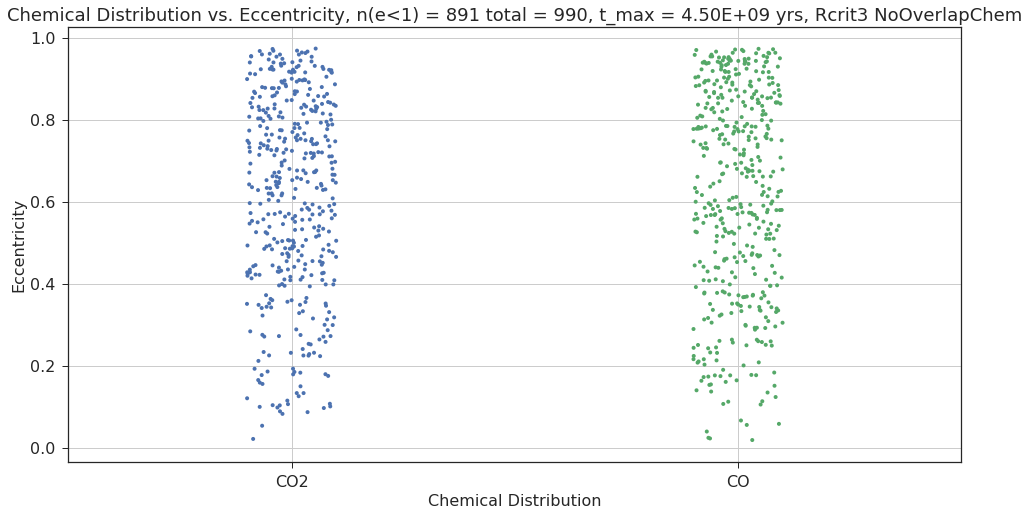

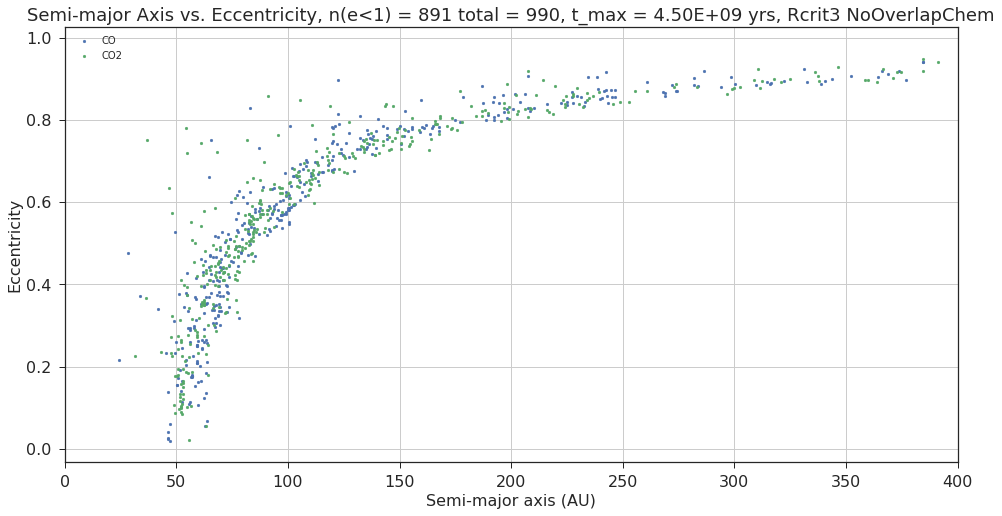

In [41]:
#Plot histograms and graph of comet semi-major axes and eccentricities (final positions)

#timescale = '%.2E' % Decimal(t_list[-1])
timescale = '%.2E' % t_list[-1]

def get_plots(orbits_a,orbits_e,df_list,df_obs,ChemDist,sim_name_,timescale,Rcrit):
    plot_a_hist(orbits_a,sim_name_,timescale,Rcrit,ChemDist)
    plot_e_hist(orbits_e,sim_name_,timescale,Rcrit,ChemDist)
    plot_chem_a(df_list,df_obs,sim_name_,timescale,Rcrit,ChemDist)
    plot_chem_e(df_list,df_obs,sim_name_,timescale,Rcrit,ChemDist)
    plot_a_e(df_list,df_obs,sim_name_,timescale,Rcrit,ChemDist)

get_plots(list(orbits_data[-1]["a"]),list(orbits_data[-1]["e"]),orbits_data,observed_orbits,ChemDist,
                      "n(e<1) = "+str((orbits_data[-1]['e'] < 1.).sum())+" total = "+str(comets_total),str(timescale),Rcrit)

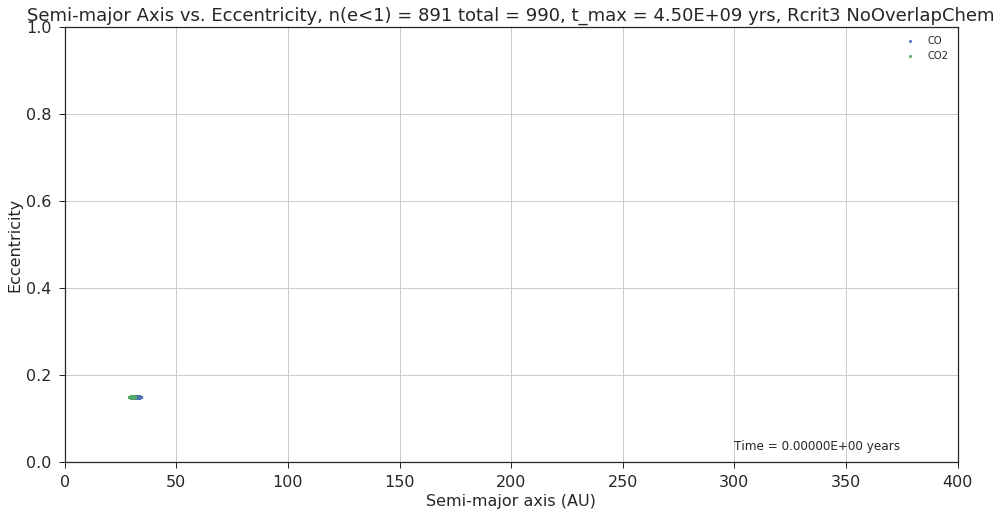

In [42]:
#Set the plot animation instance
anim = anim_a_e(orbits_data,observed_orbits,"n(e<1) = "+str((orbits_data[-1]['e'] < 1.).sum())+" total = "+str(comets_total),str(timescale),t_list,Rcrit,ChemDist)

In [ ]:
#Plot a vs e animation
HTML(anim.to_html5_video(embed_limit=500))
#HTML(anim.to_jshtml(embed_limit=500))

In [43]:
anim.save("Semi-major Axis vs. Eccentricity, n(e<1) = "+str((orbits_data[-1]['e'] < 1.).sum())+" total = "+str(comets_total)+", t_max = "+str(timescale)+" yrs "+Rcrit+" "+ChemDist+".mp4")

In [ ]:
'''#Plot number of surviving comets wrt time

print(len(comet_totals_list))
print(len(t_list))
plot_n_time(comet_totals_list, t_list, timescale, Rcrit, ChemDist)'''

## Do some statistical analysis

In [ ]:
#Simple pearson and spearman analysis
if ("BinaryChem" in ChemDist) or ("NoOverlapChem" in ChemDist):
    pear_corr_a_CO = orbits_data[-1]["a"].corr(orbits_data[-1]["CO"])
    pear_corr_e_CO = orbits_data[-1]["e"].corr(orbits_data[-1]["CO"])
    
    spear_corr_a_CO = orbits_data[-1]["a"].corr(orbits_data[-1]["CO"], method="spearman")
    spear_corr_e_CO = orbits_data[-1]["e"].corr(orbits_data[-1]["CO"], method="spearman")
    
    print("Pearson Correlation Coefficient (a to CO):",pear_corr_a_CO)
    print("Pearson Correlation Coefficient (e to CO):",pear_corr_e_CO)
    
    print("Spearman Correlation Coefficient (a to CO):",spear_corr_a_CO)
    print("Spearman Correlation Coefficient (e to CO):",spear_corr_e_CO)
    print("")
    
    pear_corr_a_CO2 = orbits_data[-1]["a"].corr(orbits_data[-1]["CO2"])
    pear_corr_e_CO2 = orbits_data[-1]["e"].corr(orbits_data[-1]["CO2"])
    
    spear_corr_a_CO2 = orbits_data[-1]["a"].corr(orbits_data[-1]["CO2"], method="spearman")
    spear_corr_e_CO2 = orbits_data[-1]["e"].corr(orbits_data[-1]["CO2"], method="spearman")
    
    print("Pearson Correlation Coefficient (a to CO2):",pear_corr_a_CO2)
    print("Pearson Correlation Coefficient (e to CO2):",pear_corr_e_CO2)
    
    print("Spearman Correlation Coefficient (a to CO2):",spear_corr_a_CO2)
    print("Spearman Correlation Coefficient (e to CO2):",spear_corr_e_CO2)

elif ("LinearChem" in ChemDist):
    pear_corr_a_chemratio = orbits_data[-1]["a"].corr(orbits_data[-1]["Chem_ratio"])
    pear_corr_e_chemratio = orbits_data[-1]["e"].corr(orbits_data[-1]["Chem_ratio"])
    print("Pearson Correlation Coefficient (a to chemratio):",pear_corr_a_chemratio)
    print("Pearson Correlation Coefficient (e to chemratio):",pear_corr_e_chemratio)
    
    print("Spearman Correlation Coefficient (a to chemratio):",spear_corr_a_chemratio)
    print("Spearman Correlation Coefficient (e to chemratio):",spear_corr_e_chemratio)
